In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").getOrCreate()
sc = spark.sparkContext


In [10]:
df = spark.read.option("header", True).csv('bread basket.csv', inferSchema=True)
df.show()

+-----------+-------------+----------------+----------+---------------+
|Transaction|         Item|       date_time|period_day|weekday_weekend|
+-----------+-------------+----------------+----------+---------------+
|          1|        Bread|30-10-2016 09:58|   morning|        weekend|
|          2| Scandinavian|30-10-2016 10:05|   morning|        weekend|
|          2| Scandinavian|30-10-2016 10:05|   morning|        weekend|
|          3|Hot chocolate|30-10-2016 10:07|   morning|        weekend|
|          3|          Jam|30-10-2016 10:07|   morning|        weekend|
|          3|      Cookies|30-10-2016 10:07|   morning|        weekend|
|          4|       Muffin|30-10-2016 10:08|   morning|        weekend|
|          5|       Coffee|30-10-2016 10:13|   morning|        weekend|
|          5|       Pastry|30-10-2016 10:13|   morning|        weekend|
|          5|        Bread|30-10-2016 10:13|   morning|        weekend|
|          6|    Medialuna|30-10-2016 10:16|   morning|        w

In [11]:
df.cache()

DataFrame[Transaction: int, Item: string, date_time: string, period_day: string, weekday_weekend: string]

In [14]:
from pyspark.sql import functions as F
transactions = df.groupBy("Transaction").agg(F.collect_set("Item").alias("items"))
transactions.show(truncate=False)

+-----------+-----------------------------------+
|Transaction|items                              |
+-----------+-----------------------------------+
|1          |[Bread]                            |
|2          |[Scandinavian]                     |
|3          |[Jam, Hot chocolate, Cookies]      |
|4          |[Muffin]                           |
|5          |[Coffee, Pastry, Bread]            |
|6          |[Pastry, Medialuna, Muffin]        |
|7          |[Coffee, Pastry, Medialuna, Tea]   |
|8          |[Pastry, Bread]                    |
|9          |[Bread, Muffin]                    |
|10         |[Scandinavian, Medialuna]          |
|11         |[Bread, Medialuna]                 |
|12         |[Tartine, Coffee, Pastry, Jam, Tea]|
|13         |[Coffee, Bread, Basket]            |
|14         |[Pastry, Bread, Medialuna]         |
|15         |[Scandinavian, Mineral water]      |
|16         |[Coffee, Bread, Medialuna]         |
|17         |[Hot chocolate]                    |


In [19]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.03, minConfidence=0.1)

model = fpGrowth.fit(transactions)

frequent_itemsets = model.freqItemsets
frequent_itemsets.show()

association_rules = model.associationRules
association_rules.show()


+------------------+----+
|             items|freq|
+------------------+----+
|         [Cookies]| 515|
|           [Juice]| 365|
|             [Tea]|1350|
|     [Tea, Coffee]| 472|
|        [Sandwich]| 680|
|[Sandwich, Coffee]| 362|
|           [Scone]| 327|
|          [Pastry]| 815|
|  [Pastry, Coffee]| 450|
|       [Alfajores]| 344|
|   [Hot chocolate]| 552|
|           [Toast]| 318|
|      [Farm House]| 371|
|           [Bread]|3097|
|   [Bread, Coffee]| 852|
|         [Brownie]| 379|
|            [Cake]| 983|
|    [Cake, Coffee]| 518|
|          [Muffin]| 364|
|            [Soup]| 326|
+------------------+----+
only showing top 20 rows

+-----------+----------+-------------------+------------------+--------------------+
| antecedent|consequent|         confidence|              lift|             support|
+-----------+----------+-------------------+------------------+--------------------+
|   [Coffee]|     [Tea]|0.10424028268551237| 0.730840204161759|0.049867934495509775|
|   [Coffe

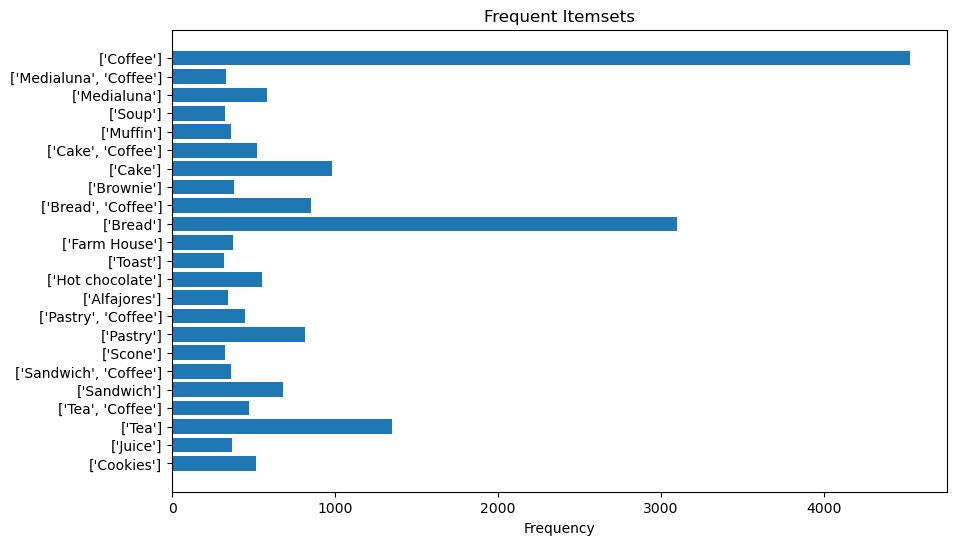

Rule: ['Coffee'] => ['Tea'], Confidence: 0.10424028268551237, Lift: 0.730840204161759
Rule: ['Coffee'] => ['Bread'], Confidence: 0.1881625441696113, Lift: 0.5750592446126481
Rule: ['Coffee'] => ['Cake'], Confidence: 0.11439929328621908, Lift: 1.101515067094673
Rule: ['Cake'] => ['Coffee'], Confidence: 0.5269582909460834, Lift: 1.101515067094673
Rule: ['Medialuna'] => ['Coffee'], Confidence: 0.5692307692307692, Lift: 1.1898783636857841
Rule: ['Tea'] => ['Coffee'], Confidence: 0.3496296296296296, Lift: 0.7308402041617589
Rule: ['Pastry'] => ['Coffee'], Confidence: 0.5521472392638037, Lift: 1.154168202215526
Rule: ['Bread'] => ['Coffee'], Confidence: 0.27510494026477234, Lift: 0.575059244612648
Rule: ['Sandwich'] => ['Coffee'], Confidence: 0.5323529411764706, Lift: 1.1127916493452503


In [43]:
import matplotlib.pyplot as plt
itemsets = [str(row.items) for row in frequent_itemsets.collect()]
frequencies = [row.freq for row in frequent_itemsets.collect()]

plt.figure(figsize=(10, 6))
plt.barh(itemsets, frequencies)
plt.xlabel('Frequency')
plt.title('Frequent Itemsets')
plt.show()

for row in association_rules.collect():
    print(f"Rule: {row.antecedent} => {row.consequent}, Confidence: {row.confidence}, Lift: {row.lift}")


### На основе полученных ассоциативных правил можно сделать следующие выводы:

1. **Низкая уверенность для некоторых правил**:
   - Правила, такие как `['Coffee'] => ['Tea']` и `['Coffee'] => ['Bread']`, имеют уверенность 10.42% и 18.82% соответственно. Это говорит о том, что покупка кофе не всегда приводит к покупке чая или хлеба, что может указывать на слабую связь между этими товарами.

2. **Сильная ассоциация для других правил**:
   - Правило `['Cake'] => ['Coffee']` имеет высокую уверенность (52.70%), что указывает на то, что покупка торта значительно повышает вероятность покупки кофе. Это может быть полезным для кросс-продаж: например, при продаже тортов можно предлагать кофе в качестве дополнения.

3. **Lift как индикатор силы ассоциации**:
   - Правило `['Cake'] => ['Coffee']` также имеет lift равный 1.10, что указывает на то, что покупка торта увеличивает вероятность покупки кофе по сравнению с независимыми покупками. Аналогично, правило `['Medialuna'] => ['Coffee']` с lift 1.19 показывает, что эта ассоциация также является сильной.

4. **Потенциал для маркетинговых стратегий**:
   - Высокие значения уверенности и lift для некоторых правил (например, `['Medialuna'] => ['Coffee']`) могут быть использованы для разработки целевых маркетинговых акций, направленных на увеличение продаж кофе вместе с другими товарами.

5. **Необходимость дальнейшего анализа**:
   - Правила с низкой уверенностью и lift (например, `['Coffee'] => ['Tea']` с lift 0.73) могут потребовать дополнительного анализа, чтобы понять, почему покупатели не склонны покупать эти товары вместе. Это может помочь в оптимизации ассортимента или в изменении подхода к маркетингу.